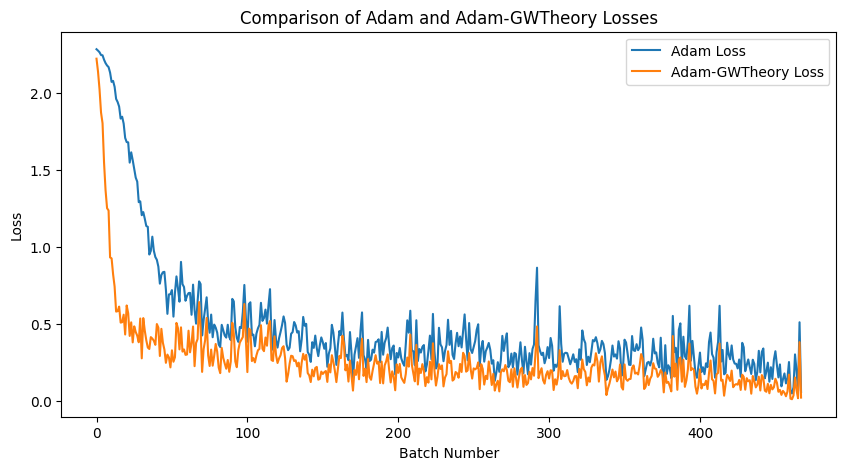

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# Load MNIST dataset
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28)).astype('float32') / 255
train_labels = to_categorical(train_labels)

# Define a simple neural network
def initialize_params(input_dim, hidden_dim, output_dim):
    np.random.seed(42)
    W1 = np.random.randn(input_dim, hidden_dim) * 0.01
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) * 0.01
    b2 = np.zeros((1, output_dim))
    return W1, b1, W2, b2

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def compute_loss(Y, Y_hat):
    m = Y.shape[0]
    return -np.sum(Y * np.log(Y_hat + 1e-8)) / m

def forward_prop(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(X, Y, Z1, A1, Z2, A2, W1, W2):
    m = X.shape[0]
    dZ2 = A2 - Y
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    return dW1, db1, dW2, db2

def update_params_with_adam(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate, t, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2, beta1, beta2, epsilon):
    mW1 = beta1 * mW1 + (1 - beta1) * dW1
    mb1 = beta1 * mb1 + (1 - beta1) * db1
    mW2 = beta1 * mW2 + (1 - beta1) * dW2
    mb2 = beta1 * mb2 + (1 - beta1) * db2
    vW1 = beta2 * vW1 + (1 - beta2) * (dW1 ** 2)
    vb1 = beta2 * vb1 + (1 - beta2) * (db1 ** 2)
    vW2 = beta2 * vW2 + (1 - beta2) * (dW2 ** 2)
    vb2 = beta2 * vb2 + (1 - beta2) * (db2 ** 2)
    mW1_corr = mW1 / (1 - beta1 ** t)
    mb1_corr = mb1 / (1 - beta1 ** t)
    mW2_corr = mW2 / (1 - beta1 ** t)
    mb2_corr = mb2 / (1 - beta1 ** t)
    vW1_corr = vW1 / (1 - beta2 ** t)
    vb1_corr = vb1 / (1 - beta2 ** t)
    vW2_corr = vW2 / (1 - beta2 ** t)
    vb2_corr = vb2 / (1 - beta2 ** t)
    W1 -= learning_rate * mW1_corr / (np.sqrt(vW1_corr) + epsilon)
    b1 -= learning_rate * mb1_corr / (np.sqrt(vb1_corr) + epsilon)
    W2 -= learning_rate * mW2_corr / (np.sqrt(vW2_corr) + epsilon)
    b2 -= learning_rate * mb2_corr / (np.sqrt(vb2_corr) + epsilon)
    return W1, b1, W2, b2, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2


last_persistence = 1  # Initialize last_persistence
base_learning_rate = 0.001  # Initialize base_learning_rate

def compute_persistence(params):

    persistence_values = [np.exp(-0.01 * np.linalg.norm(param)) for param in params]
    return np.mean(persistence_values)

def update_params_with_adam_gwtheory(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate, t, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2, beta1, beta2, epsilon):
    """
    Update parameters using Adam optimizer with Gromov-Witten theory adjustments.
    """
    global last_persistence, base_learning_rate  # Use the global variables

    # Calculate persistence and adjust learning rate dynamically
    persistence = compute_persistence([W1, b1, W2, b2])
    if persistence < last_persistence:
        learning_rate = base_learning_rate * 5  # Increase learning rate if features are less persistent
    else:
        learning_rate = base_learning_rate * 0.5  # Decrease learning rate if features are more persistent
    last_persistence = persistence

    # Update momentum and velocity
    mW1 = beta1 * mW1 + (1 - beta1) * dW1
    mb1 = beta1 * mb1 + (1 - beta1) * db1
    mW2 = beta1 * mW2 + (1 - beta1) * dW2
    mb2 = beta1 * mb2 + (1 - beta1) * db2

    vW1 = beta2 * vW1 + (1 - beta2) * (dW1 ** 2)
    vb1 = beta2 * vb1 + (1 - beta2) * (db1 ** 2)
    vW2 = beta2 * vW2 + (1 - beta2) * (dW2 ** 2)
    vb2 = beta2 * vb2 + (1 - beta2) * (db2 ** 2)

    # Apply bias correction
    mW1_corr = mW1 / (1 - beta1 ** t)
    mb1_corr = mb1 / (1 - beta1 ** t)
    mW2_corr = mW2 / (1 - beta1 ** t)
    mb2_corr = mb2 / (1 - beta1 ** t)

    vW1_corr = vW1 / (1 - beta2 ** t)
    vb1_corr = vb1 / (1 - beta2 ** t)
    vW2_corr = vW2 / (1 - beta2 ** t)
    vb2_corr = vb2 / (1 - beta2 ** t)

    # Update parameters with adjusted learning rate
    W1 -= learning_rate * mW1_corr / (np.sqrt(vW1_corr) + epsilon)
    b1 -= learning_rate * mb1_corr / (np.sqrt(vb1_corr) + epsilon)
    W2 -= learning_rate * mW2_corr / (np.sqrt(vW2_corr) + epsilon)
    b2 -= learning_rate * mb2_corr / (np.sqrt(vb2_corr) + epsilon)

    return W1, b1, W2, b2, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2

# Initialize parameters for both Adam and Adam-GWTheory
W1, b1, W2, b2 = initialize_params(784, 128, 10)
mW1, mb1, mW2, mb2 = np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2)
vW1, vb1, vW2, vb2 = np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2)

# Copy parameters for Adam-GWTheory
W1_gw, b1_gw, W2_gw, b2_gw = np.copy(W1), np.copy(b1), np.copy(W2), np.copy(b2)
mW1_gw, mb1_gw, mW2_gw, mb2_gw = np.copy(mW1), np.copy(mb1), np.copy(mW2), np.copy(mb2)
vW1_gw, vb1_gw, vW2_gw, vb2_gw = np.copy(vW1), np.copy(vb1), np.copy(vW2), np.copy(vb2)

# Training loop for Adam and Adam-GWTheory
adam_losses = []
adam_gw_losses = []
batch_size = 128
num_batches = train_images.shape[0] // batch_size

for i in range(num_batches):
    X_batch = train_images[i * batch_size:(i + 1) * batch_size]
    Y_batch = train_labels[i * batch_size:(i + 1) * batch_size]
    
    # Forward propagation for both optimizers
    Z1, A1, Z2, A2 = forward_prop(X_batch, W1, b1, W2, b2)
    Z1_gw, A1_gw, Z2_gw, A2_gw = forward_prop(X_batch, W1_gw, b1_gw, W2_gw, b2_gw)
    
    # Compute gradients
    dW1, db1, dW2, db2 = backward_prop(X_batch, Y_batch, Z1, A1, Z2, A2, W1, W2)
    dW1_gw, db1_gw, dW2_gw, db2_gw = backward_prop(X_batch, Y_batch, Z1_gw, A1_gw, Z2_gw, A2_gw, W1_gw, W2_gw)
    
    # Update parameters using Adam
    W1, b1, W2, b2, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2 = update_params_with_adam(
        W1, b1, W2, b2, dW1, db1, dW2, db2, 0.001, i+1, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2, 0.9, 0.999, 1e-8)
    
    # Update parameters using Adam-GWTheory
    W1_gw, b1_gw, W2_gw, b2_gw, mW1_gw, mb1_gw, mW2_gw, mb2_gw, vW1_gw, vb1_gw, vW2_gw, vb2_gw = update_params_with_adam_gwtheory(
        W1_gw, b1_gw, W2_gw, b2_gw, dW1_gw, db1_gw, dW2_gw, db2_gw, 0.001, i+1, mW1_gw, mb1_gw, mW2_gw, mb2_gw, vW1_gw, vb1_gw, vW2_gw, vb2_gw, 0.9, 0.999, 1e-8)

    # Calculate loss for Adam and Adam-GWTheory
    loss_adam = compute_loss(Y_batch, softmax(np.dot(relu(np.dot(X_batch, W1) + b1), W2) + b2))
    loss_ad_gw = compute_loss(Y_batch, softmax(np.dot(relu(np.dot(X_batch, W1_gw) + b1_gw), W2_gw) + b2_gw))

    adam_losses.append(loss_adam)
    adam_gw_losses.append(loss_ad_gw)

# Plotting the losses for comparison
plt.figure(figsize=(10, 5))
plt.plot(adam_losses, label='Adam Loss')
plt.plot(adam_gw_losses, label='Adam-GWTheory Loss')
plt.title('Comparison of Adam and Adam-GWTheory Losses')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7c161974-9d6a-4482-9d07-5417184f71f8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>